In [1]:
import numpy as np
from functools import partial
import os

import llmize
from llmize import OPRO
import llmize.utils

def initialize_tsp(num_cities, seed=42):
    """
    Initializes the TSP with random city coordinates.
    :param num_cities: Number of cities
    :param seed: Random seed for reproducibility
    :return: Distance matrix
    """
    np.random.seed(seed)
    cities = (np.random.rand(num_cities, 2) * 100).astype(int)  # Random cities in 100x100 space with integer coordinates
    
    # Compute distance matrix
    dist_matrix = np.sqrt(((cities[:, np.newaxis] - cities[np.newaxis, :]) ** 2).sum(axis=2))
    return cities, dist_matrix

def objective_function(route, dist_matrix):
    """
    Computes the total travel distance for a given route.
    :param route: A permutation of city indices representing the tour
    :param dist_matrix: Precomputed distance matrix
    :return: Total distance of the route
    """

    # Check if route is valid
    if len(route) != dist_matrix.shape[0]:
        return 1000

    total_distance = sum(dist_matrix[route[i], route[i+1]] for i in range(len(route) - 1))
    total_distance += dist_matrix[route[-1], route[0]]  # Return to starting city
    return total_distance


/home/rizki/anaconda3/envs/genai_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
num_cities = 10
cities, dist_matrix = initialize_tsp(num_cities)
# generate 5 random routes and total distances
routes = [np.random.permutation(num_cities) for _ in range(5)]
total_distances = [objective_function(route, dist_matrix) for route in routes]

print(np.shape(dist_matrix))
print(routes)
print(total_distances)


(10, 10)
[array([1, 5, 4, 8, 0, 7, 6, 3, 2, 9]), array([8, 2, 5, 7, 3, 1, 9, 0, 4, 6]), array([0, 5, 2, 6, 3, 7, 4, 1, 8, 9]), array([4, 8, 1, 3, 0, 5, 2, 9, 7, 6]), array([2, 0, 4, 9, 8, 6, 7, 5, 1, 3])]
[np.float64(613.5193087234638), np.float64(602.1802669511267), np.float64(576.2101779671258), np.float64(479.824972974584), np.float64(618.7658994262118)]


In [3]:
print(cities)

[[37 95]
 [73 59]
 [15 15]
 [ 5 86]
 [60 70]
 [ 2 96]
 [83 21]
 [18 18]
 [30 52]
 [43 29]]


In [4]:
with open("tsp_problem.txt", "r") as f:
    problem_text = f.read()

# Initialize the OPRO optimizer
opro = OPRO(problem_text=problem_text, obj_func=partial(objective_function, dist_matrix=dist_matrix),
            llm_model="gemini-2.0-flash", api_key=os.getenv("GEMINI_API_KEY"))

prompt = opro.get_sample_prompt(init_samples=routes, init_scores=total_distances, optimization_type="minimize")
response = opro.get_sample_response(prompt)

llmize.utils.pretty_print(prompt=prompt, response=response)



Prompt: I want you to help me solve the Traveling Salesman Problem (TSP) for 10 randomly placed cities within a 
100x100 coordinate space. The objective is to find the shortest possible route that visits each city exactly once 
and returns to the starting point.

In the TSP, the goal is to minimize the total distance traveled by visiting each city only once and returning to 
the starting city, creating a closed loop. The cities are represented as points on a 2D grid, where each city has 
an x and y coordinate within the 100x100 space.

Below are each city coordinate  from 0 to 9:
 [37, 95]
 [73, 59]
 [15, 15]
 [ 5, 86]
 [60, 70]
 [ 2, 96]
 [83, 21]
 [18, 18]
 [30, 52]
 [43, 29]

For each pair of cities, the distance between them is calculated using the Euclidean distance formula. The distance
between two cities is the square root of the sum of the squared differences between their x and y coordinates.
Below are some examples of solutions and their scores:
<sol> 1,5,4,8,0,7,6,3,2,9 <\sol>
score: 613.52

<sol> 8,2,5,7,3,1,9,0,4,6 <\sol>
score: 602.18

<sol> 0,5,2,6,3,7,4,1,8,9 <\sol>
score: 576.21

<sol> 4,8,1,3,0,5,2,9,7,6 <\sol>
score: 479.82

<sol> 2,0,4,9,8,6,7,5,1,3 <\sol>
score: 618.77

Generate exactly 5 new solutions that:
- Are distinct from all previous solutions.
- Have lower scores than the lowest provided.
- Respect the relationships based on logical reasoning.

Each solution should start with <sol> and end with <\sol> with a comma between parameters. 
Make sure the length of solutions match examples given. Don't guess for the scores as they will be calculated by an
objective function.

Response: Here are 5 new solutions for the Traveling Salesman Problem, attempting to improve on the best score of 
479.82 from the examples:

<sol> 2,7,9,6,1,4,0,3,5,8 <\sol>
<sol> 7,2,8,9,1,6,4,0,3,5 <\sol>
<sol> 9,7,6,8,1,4,0,3,5,2 <\sol>
<sol> 2,7,9,8,6,1,4,0,5,3 <\sol>
<sol> 9,7,8,6,1,4,0,5,3,2 <\sol>

In [5]:
from llmize.utils.parsing import parse_pairs, parse_response

pairs = parse_response(response)
print(pairs)

[[2, 7, 9, 6, 1, 4, 0, 3, 5, 8], [7, 2, 8, 9, 1, 6, 4, 0, 3, 5], [9, 7, 6, 8, 1, 4, 0, 3, 5, 2], [2, 7, 9, 8, 6, 1, 4, 0, 5, 3], [9, 7, 8, 6, 1, 4, 0, 5, 3, 2]]


In [ ]:
from llmize.callbacks import EarlyStopping, AdaptTempOnPlateau

# Define the early stopping callback
earlystop_callback = EarlyStopping(monitor='best_score', min_delta=1.0, patience=20, verbose=0)

# Define the temperature adaptation callback
adapt_temp_callback = AdaptTempOnPlateau(monitor='best_score', init_temperature=1.0, min_delta=1.0, patience=5, factor=1.1, max_temperature=1.9, verbose=1)

In [7]:
callbacks=[earlystop_callback, adapt_temp_callback]
print(callbacks)

[<llmize.callbacks.early_stopping.EarlyStopping object at 0x7fa03cdecd70>, <llmize.callbacks.adapt_temp_on_plateau.AdaptTempOnPlateau object at 0x7fa03cdee3c0>]


In [8]:
results = opro.minimize(init_samples=routes, init_scores=total_distances, batch_size=5, callbacks=callbacks)

Running OPRO optimization with 50 steps and batch size 5...
Step 0 - Best Initial Score: 479.82, Average Initial Score: 578.10
Step 1 - Current Best Score: 356.81, Average Batch Score: 394.93 - Best Batch Score: 356.81
Step 2 - Current Best Score: 356.81, Average Batch Score: 457.98 - Best Batch Score: 420.78
Step 3 - Current Best Score: 356.81, Average Batch Score: 497.07 - Best Batch Score: 464.61
Step 4 - Current Best Score: 356.81, Average Batch Score: 449.15 - Best Batch Score: 412.22
Step 5 - Current Best Score: 356.81, Average Batch Score: 433.88 - Best Batch Score: 420.57
No improvement in best_score for 5 steps. Adapted temperature to 1.20.
Step 6 - Current Best Score: 356.81, Average Batch Score: 410.16 - Best Batch Score: 368.44
Number of solutions parsed is not equal to batch size. Retrying...
Step 7 - Current Best Score: 356.81, Average Batch Score: 414.40 - Best Batch Score: 375.40
Step 8 - Current Best Score: 356.81, Average Batch Score: 394.23 - Best Batch Score: 375.40

In [13]:

print(results['best_solution'])
print(results['best_score'])

[3, 5, 0, 4, 1, 7, 2, 9, 6, 8]
344.99681262726824


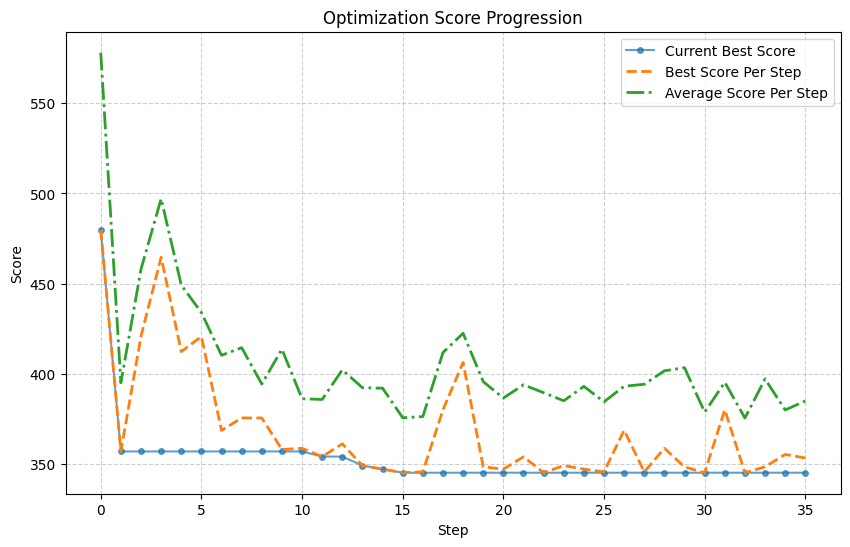

In [14]:
from llmize.utils.plotting import plot_scores

plot_scores(results)

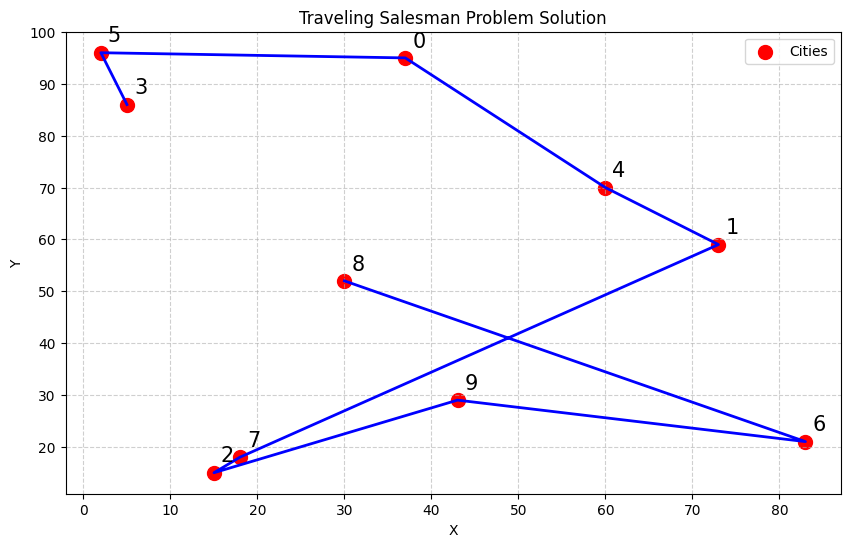

In [15]:
# Plot city coordinates along with traces from best solution
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.scatter(cities[:, 0], cities[:, 1], c='r', s=100, label='Cities')

solution = results['best_solution']
plt.plot(cities[solution, 0], cities[solution, 1], color='b', linewidth=2)

# Annotate city number a distance to the dots
for i, city in enumerate(cities):
    plt.annotate(str(i), xy=(city[0], city[1]), xytext=(5, 5),fontsize=15, textcoords='offset points', ha='left', va='bottom')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Traveling Salesman Problem Solution')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [16]:
print(solution)

[3, 5, 0, 4, 1, 7, 2, 9, 6, 8]
